In [12]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
from tqdm import tqdm

NLP Inputs

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding,LSTM,Input,Dropout,Dense,add,Concatenate,Reshape,concatenate,Bidirectional

model creation and computer vision imputs

In [3]:
#model creation import
from tensorflow.keras.models import Sequential,Model
#computer vision imputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications import DenseNet201
#Model Learning &losses Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

| Import               | Role                          | Analogy                   |
| -------------------- | ----------------------------- | ------------------------- |
| `Sequential`         | Simple linear model           | Stack of layers 🍔        |
| `Model`              | Flexible model design         | Custom pipeline 🧩        |
| `ImageDataGenerator` | Augment + preprocess images   | Auto photo editor 📸      |
| `load_img`           | Load image from disk          | Open picture 🖼️          |
| `img_to_array`       | Convert image → numbers       | Turn photo into pixels 🔢 |
| `DenseNet201`        | Pretrained CNN base           | Borrow smart eyes 👀      |
| `Adam`               | Optimizer (controls learning) | Learning coach 🧠         |
| `ModelCheckpoint`    | Save best model               | Auto backup 💾            |
| `EarlyStopping`      | Stop training early           | “Stop, we’re done!” ✋     |
| `ReduceLROnPlateau`  | Slow down learning when stuck | Gentle fine-tuning ⚙️     |

| Concept     | `Sequential`               | `Model` (Functional API)                         |
| ----------- | -------------------------- | ------------------------------------------------ |
| Structure   | Straight line              | Custom graph (you draw connections)              |
| Inputs      | One                        | One or many                                      |
| Outputs     | One                        | One or many                                      |
| Flexibility | Limited                    | Very flexible                                    |
| Example use | Simple CNN or MLP          | Complex models like ResNet, multi-input networks |
| Analogy     | Train on a single track 🚆 | City map with roads connecting everywhere 🛣️    |


In [4]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

| Import              | What it does                 | Simple meaning           |
| ------------------- | ---------------------------- | ------------------------ |
| `warnings`          | Controls warning messages    | Keeps console clean      |
| `matplotlib.pyplot` | Creates basic plots & graphs | Draw charts manually     |
| `seaborn`           | Makes advanced, pretty plots | Stylish & simpler charts |
| `textwrap.wrap`     | Splits long text into lines  | Helps fit text neatly    |


In [5]:
warnings.filterwarnings('ignore')

In [6]:
image_path='/kaggle/input/flickr8k/Images'
data=pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
def text_preprocessing(data):
    data['caption']=data['caption'].apply(lambda x:x.lower())
    data['caption']=data['caption'].apply(lambda x:x.replace("[^A-Za-z]",""))
    #//this removes excess space
    data['caption']=data['caption'].apply(lambda x:x.replace("\s"," "))
    data['caption']=data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption']="startseq "+data['caption']+" endseq"

    return data

data=text_preprocessing(data)
    

In [8]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data['caption'])


vocab_size=len(tokenizer.word_index)+1

max_length=max([len(c.split()) for c in data['caption']])
tokenizer.texts_to_sequences([data['caption'][0]])

images=data['image'].unique().tolist()
nimages=len(images)



In [9]:
split_index=round(0.85*nimages)
train_images=data['image'][:split_index]
test_images=data['image'][split_index:]

In [10]:
train=data[data['image'].isin(train_images)]
test=data[data['image'].isin(test_images)]
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [11]:
model = DenseNet201(weights=None)

fe=Model(inputs=model.input,outputs=model.layers[-2].output)
img_size=224
features={}

for image in tqdm(data['image'].unique().tolist()):
    img=load_img(os.path.join(image_path,image),target_size=[img_size,img_size])
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,axis=0)
    feature=fe.predict(img,verbose=0)
    features[image]=feature
    
    


2025-11-08 06:45:04.667634: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
100%|██████████| 8091/8091 [35:57<00:00,  3.75it/s]


In [13]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [14]:
train_generator[0]

((array([[0.        , 0.00603114, 0.01018817, ..., 0.01958847, 0.0018878 ,
          0.01223324],
         [0.        , 0.00603114, 0.01018817, ..., 0.01958847, 0.0018878 ,
          0.01223324],
         [0.        , 0.00603114, 0.01018817, ..., 0.01958847, 0.0018878 ,
          0.01223324],
         ...,
         [0.        , 0.01289374, 0.00781189, ..., 0.01756956, 0.0024795 ,
          0.01794193],
         [0.        , 0.01289374, 0.00781189, ..., 0.01756956, 0.0024795 ,
          0.01794193],
         [0.        , 0.01289374, 0.00781189, ..., 0.01756956, 0.0024795 ,
          0.01794193]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,  49,   4, 210]], dtype=int32)),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.

In [19]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)




history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - loss: 7.0017
Epoch 1: val_loss improved from inf to 5.74081, saving model to model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - loss: 6.9944 - val_loss: 5.7408 - learning_rate: 0.0010
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - loss: 5.5474
Epoch 2: val_loss improved from 5.74081 to 5.28129, saving model to model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - loss: 5.5462 - val_loss: 5.2813 - learning_rate: 0.0010
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - loss: 5.0732
Epoch 3: val_loss improved from 5.28129 to 5.05941, saving model to model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - loss: 5.0727 - val_loss: 5.0594 - learning_rate: 0.0010
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - loss: 4.8420
Epoch 4: val_loss improved from 5.05941 to 4.92363, saving model to model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - loss: 4.8416 - val_loss: 4.9236 - learning_rate: 0.0010
Epoch 5/

In [21]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [22]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

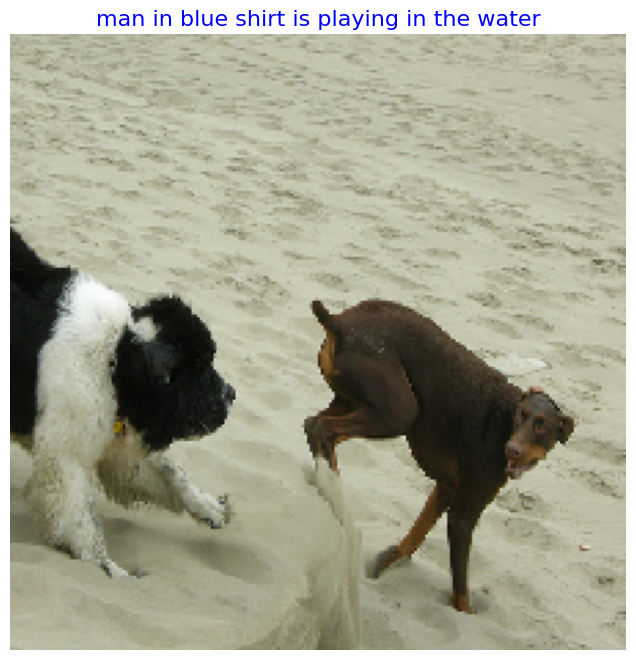

In [30]:
image_path = "/kaggle/input/flickr8k/Images/1067790824_f3cc97239b.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)